# DotPlots

KSTAR results are best visualized with a DotPlot, which indicates degree of activity by the size of a dot and significance by its colors. This notebook outlines how to create these plots, either with our web app or directly in python.

## With Interactive Web App

To help with the visualization of the data, we have created an interactive web app for plotting KSTAR activities, which will take the generated 'experiment_name_mann_whitney_activities.tsv' and 'experiment_name_mann_whitney_fpr.tsv' files as input. The web app can be accessed at the following link: [KSTAR Plotting Tool](https://proteomescout.research.virginia.edu/kstar/). This app is still in early stages of development, so please feel free to submit tickets for feature requests or any bugs that you encounter at the github repository: [KSTAR Plotting Tool Github](https://github.com/srcrowl/KSTAR_Plotting_Tool).

## In Python

Alternatively, if you would like greater flexibility in plotting the data, you can craft your own plots within python using the DotPlot class (same as used in the web app).

In [1]:
#import necessary packages
import pandas as pd
from kstar.plot import DotPlot
from kstar import calculate

odir = './example'
name = 'example_run'
phosphomod = 'Y'

### Load KSTAR Results

To load a kstar save, use the 'from_kstar' function

In [2]:
#Load kstar_slim save
kinact_dict = calculate.from_kstar(name, odir)

If nextflow was used (see Running Large Datasets with Nextflow), there is a seperate function that will allow you to load in results from nextflow into a kinase_dict object:

In [3]:
kinact_dict = calculate.from_kstar_nextflow(name = 'example_run',odir = 'example_run')

Lastly, you may only be concerned about the predicted activities and false positive rates. If that is the case, load these directly with pandas:

In [ ]:
results = pd.read_csv(f"{odir}/RESULTS/{name}_Y_mann_whitney_activities.tsv", sep = '\t', index_col = 0)
fpr = pd.read_csv(f"{odir}/RESULTS/{name}_Y_mann_whitney_fpr.tsv", sep = '\t', index_col = 0)

### Plot Results

Kinase activities predicted by KSTAR can be visualized using a specialized plot called a dotplot. In these plots, the size of each "dot" is dictated by the -log10(p-value) and the color is dicated by the false positive rate (significance).

#### Plot the base dotplot

In the most simple case, we can plot all kinases and samples with activity predictions, sorted in the same order as the provided activities/fpr dataframe. First, we need to extract the activity and false positive rate from the kinact_dict object, and pass those to the dotplot class.

<Axes: >

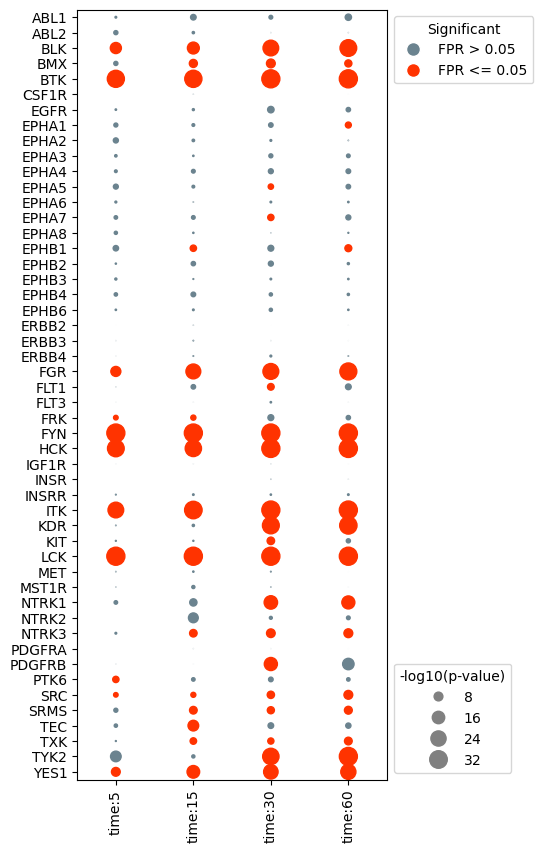

In [3]:
#if using kinase_dict object, extract results and fpr values
activities = kinact_dict['Y'].activities_mann_whitney.copy()
fpr = kinact_dict['Y'].fpr_mann_whitney.copy()

#instantiate the dotplot object
dots = DotPlot(activities, 
               fpr, 
               figsize = (4,10))

#generate the dotplot
dots.dotplot()

#### Change the axis labels and sort kinases based on activity

In many cases, you may wish to plot different axis labels for each experiment or use different naming conventions then those that are defaults in NetworKIN. To adjust, you can manually update the results and fpr dataframe prior to creating the dotplot object. Or, you can pass in dictionaries to the dotplot object that will adjust the axis labels accordingly without changing the original activities/fpr dataframes.

In this example, the x-axis labels are a bit wordy. Let's simplify it to just include the numeric time value. In addition, we would like to change the kinase labels so that kinases like KDR (VEGFR2) are indicated by their more well known name.

In [4]:
#create the xlabel dict to remove 'data' and 'time' from x-axis labels
x_label_dict = {}
for i in range(len(activities.columns)):
    x_label_dict[activities.columns[i]] = activities.columns[i].split(':')[2]
    
x_label_dict

{'data:time:5': '5',
 'data:time:15': '15',
 'data:time:30': '30',
 'data:time:60': '60'}

In addition, we would like to change the kinase labels so that kinases like KDR (VEGFR2) are indicated by their more well known name.

In [5]:
#set preferred kinase names (make a kinase_dict)
kinase_dict = {}
kinase_map = pd.read_csv('globalKinaseMap.csv', index_col = 0)
for kinase in activities.index:
    kinase_dict[kinase] = kinase_map.loc[kinase,'Preferred Name']

Any sorting of the results needs to be done before instantiating the dotplot. Only the activities dataframe needs to be updated, the fpr dataframe will be automatically updated in order to match the activities dataframe.

In [6]:
#sort the data by the activities at the 30 second timepoint
activities.sort_values(by = 'data:time:30', inplace = True)
#reorder axis labels to be in time order
activities = activities[['data:time:5','data:time:15','data:time:30', 'data:time:60']]

<Axes: >

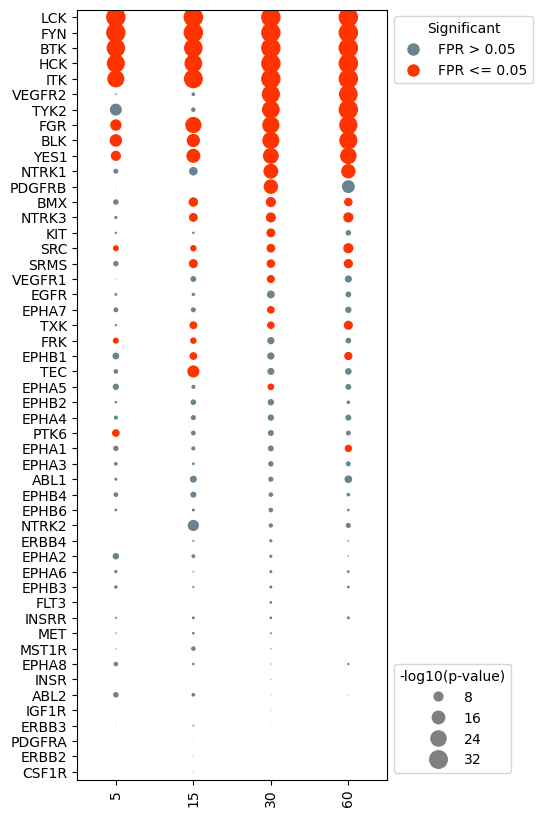

In [7]:
#reinstantiate the dotplot object
dots = DotPlot(activities, 
               fpr, 
               x_label_dict = x_label_dict,
               kinase_dict = kinase_dict,
               figsize = (4,10),
               legend_title = '-log10(p-value)')

#plot
dots.dotplot()

#### Remove kinases that never show significant activity

In many cases, there will be kinases that do not show significant activity in any of the experiments. It can be advantageous to remove these kinases in order to simplify the plot.

<Axes: >

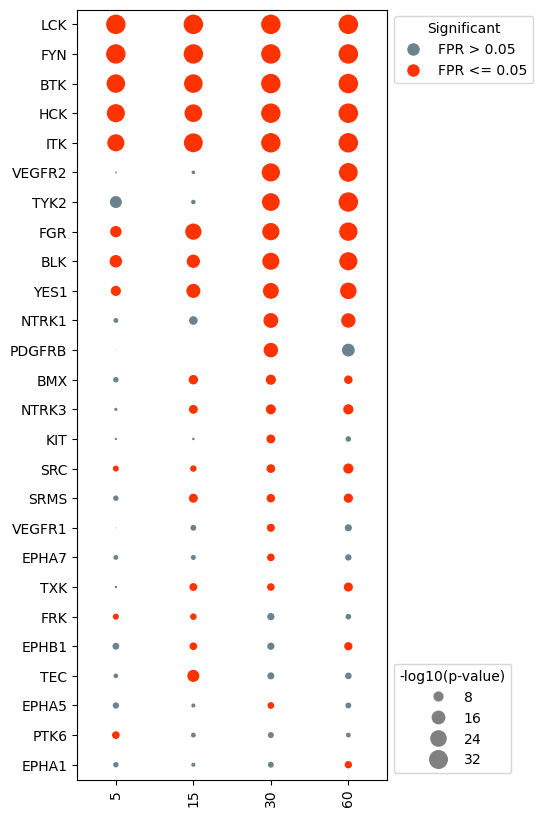

In [8]:
#drop kinases with that are not significant for any of the samples (fpr <= alpha). 
dots.drop_kinases_with_no_significance()

#generate the dotplot
dots.dotplot()

Specific kinases can also be removed prior to plotting. For example, say we were less interested in the activity in EPHA kinases. We can tell the dotplot object to remove these kinases specifically.

<Axes: >

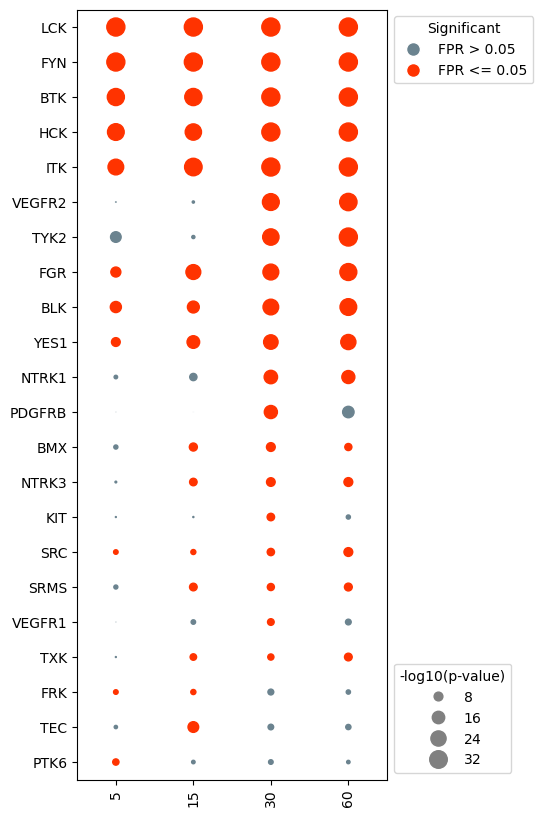

In [9]:
#drop kinases that are not of interest. For example, we may not be interested in visualizing EPHA kinases.
eph = [kin for kin in activities.index if 'EPHA' in kin or 'EPHB' in kin]
dots.drop_kinases(eph)

#generate the dotplot
dots.dotplot()

#### More complex plots

In addition to the base dotplot, we can also cluster kinases/samples, add additional context, and plot evidence sizes. For this, it's recommended to use the `DotPlot.make_complete_dotplot()` function. See the next sections for examples

##### Cluster the kinase activities

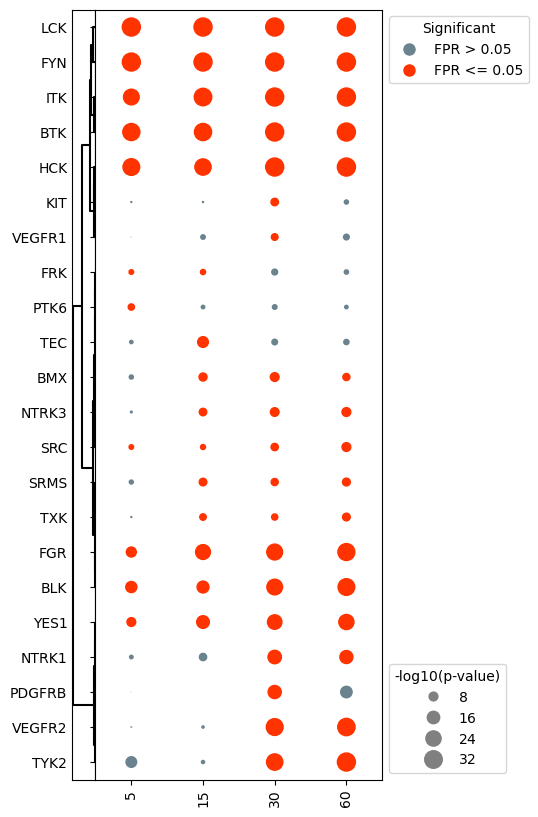

In [10]:
dots.make_complete_dotplot(significant_kinases_only=True,
                           cluster_kinases=True)

Notice that clustering the kinase activities resorted the y-axis, undoing the sorting from earlier.

#### Add context to dotplot

In some cases you may want to add additional context to the dotplot that indicates significant characteristics about each sample. These could include things like pre vs. post-treatment, normal vs. tumor sample, subtype of cancer, etc. 

To do so, you need to create a new dataframe, which contains a row for each sample in the dotplot (with an id column indicating the sample), and columns for each layer of context you want to be added. In the below example, we will add "Context 1" to the plot, which is either true or false. "Context 2" has multiple different options indicated by a number.

In [11]:
#create context dataframe which indicates different information about each sample
context = pd.DataFrame({'Sample': activities.columns, 'Context 1': ['Yes','Yes','No','No'], 'Context 2': ['0','1','2','3']})
context

Sample Context 1 Context 2
0   data:time:5       Yes         0
1  data:time:15       Yes         1
2  data:time:30        No         2
3  data:time:60        No         3

Next to plot, with the context information above, setup your subplots as before, but this time, make sure to add another subplot row above the dotplot, which will contain the context strip.

We can then use the 'context' function to add context dots for each sample by passing the context dataframe to the `make_complete_dotplot()` function. The following parameters need to be included:
 - `context`: dataframe containing context info
 - `id_column`: column containing sample names
 - `context_columns`: list of column names that have specific context information (can be multiple)

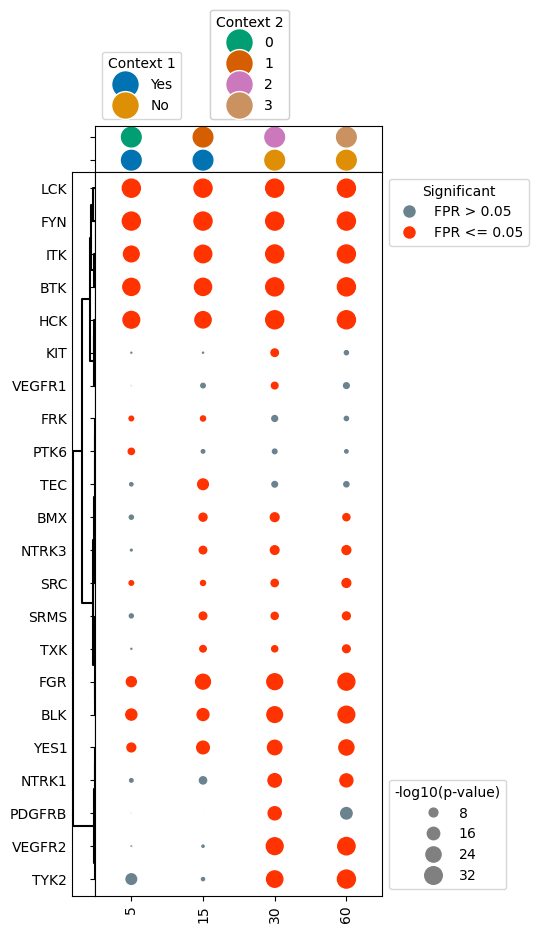

In [12]:
dots.make_complete_dotplot(significant_kinases_only=True,
                           cluster_kinases=True,
                           context = context, id_column = 'Sample', context_columns = ['Context 1','Context 2'])

#### Plot dotplot with the false positive rate indicated by hue

In some cases, the binary coloring of significance can make certain kinases appear less significant than they really are, with false positive rates hovering around 0.05. As such, it may be of interest to encode the false positive rate using a gradient hue instead. This is easy to accomplish in the dotplot class, as this is controlled by the binary_sig parameter.

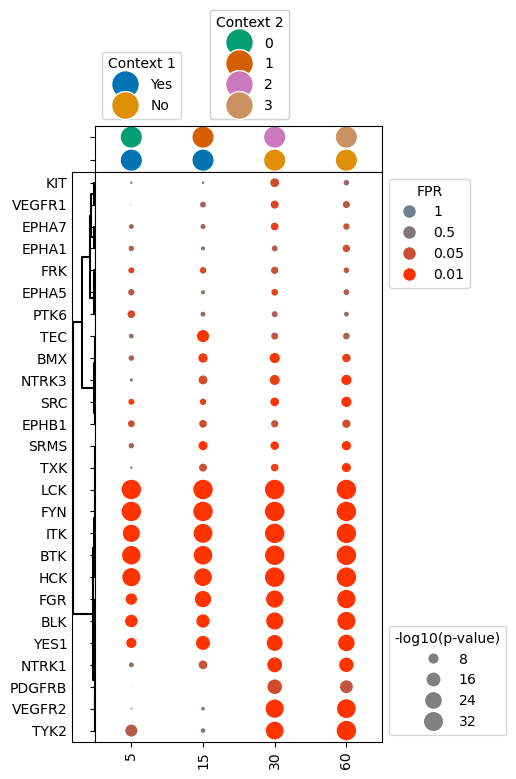

In [13]:

#reinstantiate the dotplot object, this time with binary_sig set to False
dots = DotPlot(activities, 
               fpr, 
               binary_sig = False, #change this parameter
               x_label_dict = x_label_dict,
               kinase_dict = kinase_dict,
               legend_title = '-log10(p-value)')

#repeat the same processing steps as before
dots.make_complete_dotplot(significant_kinases_only=True,
                           cluster_kinases=True,
                           context = context, id_column = 'Sample', context_columns = ['Context 1','Context 2'])

#### Indicate evidence size for sample

It can sometimes be useful to understand how many phosphorylation sites were used as evidence for each sample, as samples with too few sites may produce unhelpful/unreliable predictions. We have provided functionality to indicate the number of sites used for each sample, as well as indicate when sample size may be too low for reliable predictions. There are two versions of this annotation to choose from:
- Bars: bar plot indicating size, with recommended evidence sizes shown as horizontal lines, and samples with too few sites appearing as faint gray bars.
- dots: dots with increasing size for increasing number of sites used, with the dot colored based on whether their is sufficient evidence for prediction.

In order to add this layer of information, we need to know the binary evidence used, so load this in, either from kinact_dict or directly from file.

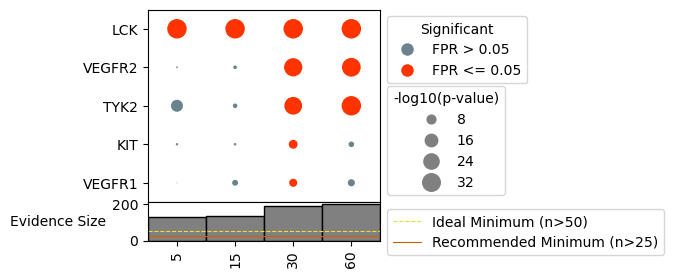

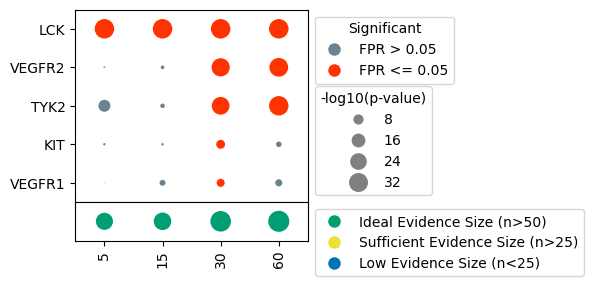

In [17]:
binary_evidence = kinact_dict['Y'].evidence_binary.copy()
#reinstantiate the dotplot object
dots = DotPlot(activities, 
               fpr, 
               figsize = (3, 3),
               x_label_dict = x_label_dict,
               kinase_dict = kinase_dict,
               legend_title = '-log10(p-value)')


###### Bars Version #######

#repeat the same processing steps as before
dots.make_complete_dotplot(kinases_to_plot = ['LCK', 'TYK2', 'KIT'],
                           binary_evidence = binary_evidence,
                           plot_type = 'bars',
                           include_recommendations = True,
                           phospho_type = 'Y')

###### Dots Version ######

#plot evidence size
dots.make_complete_dotplot(kinases_to_plot = ['LCK', 'TYK2', 'KIT'],
                           binary_evidence= binary_evidence,
                           plot_type = 'dots',
                           include_recommendations = True,
                           phospho_type = 'Y')